In [1]:
import numpy
import matplotlib.pyplot as plt
import math

In [10]:
display_constants=True
# Define constants
kb = 8.6173303e-5*1.6022e-19 # Boltzmann constant in J/K
h = 4.135667662e-15*1.6022e-19 # Planck constant in J*s
h_bar = h/(2*math.pi) # Reduced Planck constant in J*s
pi = math.pi # Pi
p_0 = 1.01325e5 # Pressure in Pa (1 atm)
N_avogadro = 6.022140857e23 # Avogadro's number
m = 2.6566962e-26*2 #mass of single O2 molecule in kg
sigma_sym = 2 # Symmetry number of O2 molecule (2 for homonuclear diatomic, 1 for heteronuclear diatomic)
I_spin = 3 # Electronic spin degeneracy of O2 molecule
B_0 = 0.18/1000*1.6022e-19 # Rotational constant in J
omega_0 = 4.739261388e13 # s^-1; tabulated at: 0.196 eV; corresponds to 4.739261388e13 Hz frequency

if(display_constants):
    print("kb = ",kb," J/K","B_0 = ",B_0," J","omega_0 = ",omega_0," J","h = ",h," J*s","p_0 =",p_0, "Pa","m = ",m," kg","sigma_sym = ",sigma_sym," ","I_spin = ",I_spin)


kb =  1.380668660666e-23  J/K B_0 =  2.88396e-23  J omega_0 =  47392613880000.0  J h =  6.6261667280564e-34  J*s p_0 = 101325.0 Pa m =  5.3133924e-26  kg sigma_sym =  2   I_spin =  3


In [3]:
def load_janaf_csv(filename):
    '''
    Loads a JANAF .csv file and returns the data as a numpy array
    Inputs
    ------
        filename: string
            Name of the JANAF file to load
    Returns
    -------
        data: numpy array
            Data from the JANAF file
    '''
    data = numpy.genfromtxt(filename, skip_header=2)
    data_dict = {}
    data_dict["T"] = data[:,0] #K
    data_dict["Cp"] = data[:,1] #J/mol*K
    data_dict["S"] = data[:,2] # J/mol*K
    data_dict["-[G-H(Tr)]/T"] = data[:,3] #J/mol*K
    data_dict["H-H(Tr)"] = data[:,4]*1000 # originally kJ/mol, converted to J/mol
    return data_dict


In [7]:
def calculate_mu_from_janaf(janaf_filename,T_min=0,T_max=9999):
    '''
        Takes janaf data and calculates chemical potential of the species for the specified T-range (ideally the relevant T-range)
        Executes (H-H(Tr)) - TS = G-H(Tr) and returns [G-H(Tr)]/N_avogadro

        Inputs
        ------
            janaf_filename: string
                Name of the JANAF file to load
            T_min: float
                Minimum temperature in K, defaults to 0
            T_max: float
                Maximum temperature in K, defaults to 9999 (presumably you don't have data above 9999K)
        Returns
        -------
            mu_O: numpy array
                Chemical potential of oxygen (1/2 O2) in eV
            T: numpy array
                Temperature in K
    '''
    janaf_data = load_janaf_csv(janaf_filename)
    # make sure lengths are all the same, print warning if not
    if len(janaf_data["T"]) != len(janaf_data["Cp"]) or len(janaf_data["T"]) != len(janaf_data["S"]) or len(janaf_data["T"]) != len(janaf_data["-[G-H(Tr)]/T"]) or len(janaf_data["T"]) != len(janaf_data["H-H(Tr)"]):
        print("Warning: Lengths of data arrays are not equal!")
    # make sure T is in ascending order, print warning if not
    if not numpy.all(numpy.diff(janaf_data["T"]) > 0):
        print("Warning: Temperature array is not in ascending order!")
    # trim janaf data to relevant T range
    T = janaf_data["T"][(janaf_data["T"] >= T_min) & (janaf_data["T"] <= T_max)]
    Cp = janaf_data["Cp"][(janaf_data["T"] >= T_min) & (janaf_data["T"] <= T_max)]
    S = janaf_data["S"][(janaf_data["T"] >= T_min) & (janaf_data["T"] <= T_max)]
    delta_G = janaf_data["-[G-H(Tr)]/T"][(janaf_data["T"] >= T_min) & (janaf_data["T"] <= T_max)]
    H = janaf_data["H-H(Tr)"][(janaf_data["T"] >= T_min) & (janaf_data["T"] <= T_max)]
    # calculate mu
    mu = ((H - T*S)/N_avogadro)/1.602176634e-19 # eV
    return mu, T
    



In [8]:
def oxygen_delta_mu_0(T,p=p_0):
    '''
    Calculates the delta chemical potential of oxygen in eV, given a temperature in K and pressure in Pa.
    Inputs
    ------
        T: float
            Temperature in K
        p: float
            Pressure in Pa, default is 1 atm (1.01325e5 Pa)
    Returns
    -------
        delta_mu_O: float
            Chemical potential of oxygen (1/2 O2) in eV
    '''
    # Define partition function components
    q_trans=(2*pi*m/(h**2))**1.5*((kb*T)**2.5)/p #technically this is more like q_trans-pV term

    ###DEBUG###
    print(math.log(q_trans))
    print(math.log(kb*T/(sigma_sym*B_0)))
    print(math.log(1-math.exp(-h*omega_0/(kb*T))))
    print(math.log(I_spin))
    print('-------------')
    ###DEBUG###
    #q_rot = sum{J=0->infinite}[(2J+1)exp(-J(J+1)B_0/kb*T)]
    #after Euler-Maclaurin approx, and an approximation where we group complications due to indistinguishable particles into the sigma_sym factor, we get: (at relevant temperatures where rotational level spacing <<kb*T)
    #mu_rot=-kb*T*math.log(kb*T/(sigma_sym*B_0))
    #q_vib = sum{i=1->M,n=0->infinite}[exp(-(n+0.5)h_bar*omega_i/(kb*T))] #M is number of vibrational modes, omega_i for the molecule
    #evaluating
    #mu_vib=sum{i=1->M}[h_bar*omega_i/(kb*T)+kb*T*math.log(1-exp(-h_bar*omega_i/(kb*T)))]
    #mu_elec=math.log(I_spin) #I_spin is the electronic spin degeneracy of the molecule

    #delta_mu_O2 = -h*omega_0/(kb*T)
    delta_mu_O2 = -kb*T*(math.log(q_trans) + math.log(kb*T/(sigma_sym*B_0)) - math.log(1-math.exp(-h*omega_0/(kb*T))) + math.log(I_spin) )# Oxygen chemical potential in J, single molecule
    ''' - math.log(1-math.exp(h_bar*omega_0/(kb*T))) + math.log(I_spin)'''
    delta_mu_O = delta_mu_O2/2
    return delta_mu_O/1.602176634e-19 # converted to eV

In [9]:
def oxygen_mu_0(T,p=p_0,calc_type="None"):
    '''
    Calculates the chemical potential of oxygen in eV, given a temperature in K and pressure in Pa.
    Inputs
    ------
        T: float
            Temperature in K
        p: float
            Pressure in Pa, default is 1 atm (1.01325e5 Pa)
        calc_type: string
            Calculation type, default is None (sets no offset). Other options are "PBE", "SCAN", "R2SCAN"
    Returns
    -------
        mu_O: float
            Chemical potential of oxygen (1/2 O2) in eV
    '''
    if (calc_type=="None"):
        vasp_mu_O = 0.0
    elif(calc_type=="PBE"):
        vasp_mu_O = (-9.87432174+1.36)/2 #PBE O2 molecule (corrected by 1.36eV/O2 [following Ceder paper])
    elif(calc_type=="SCAN"):
        vasp_mu_O = -5.950312485 #SCAN O2 molecule/2 (uncorrected, will need to validate for SCAN)
    elif(calc_type=="R2SCAN"):
        vasp_mu_O = 0.0 #unimplemented for R2SCAN
        print("R2SCAN not yet implemented")
    #print("VASP reference chemical potential is: ", )
    mu_O = vasp_mu_O + oxygen_delta_mu_0(T,p)
    return mu_O

In [11]:
# Load JANAF data
O2_janaf = calculate_mu_from_janaf("/home/jonnyli/Documents/McQuarrie/JANAF/O-029.txt",T_min=0,T_max=1000)
#print(O2_janaf)
O_janaf = (O2_janaf[0]/2,O2_janaf[1])
TiO2_janaf = calculate_mu_from_janaf("/home/jonnyli/Documents/McQuarrie/JANAF/TiO2-anatase-042.txt",T_min=0,T_max=1000)
Ti_ref_janaf = calculate_mu_from_janaf("/home/jonnyli/Documents/McQuarrie/JANAF/Ti-alpha-002.txt",T_min=0,T_max=1000)


# Define temperature range
T = numpy.linspace(0.1,1000) # Temperature in K
# Calculate oxygen chemical potential
delta_mu_O = numpy.zeros(len(T))
for i in range(len(T)):
    delta_mu_O[i] = oxygen_mu_0(T[i],calc_type="None")

# calculate dG = G(TiO2)_vasp - G(Ti)_vasp - mu(O2)_vasp - dG_janaf




-4.222831423372932
-3.7323287047213918
0.0
1.0986122886681098
-------------
9.085440053120452
1.5909798858759616
0.0
1.0986122886681098
-------------
10.812204820361693
2.281685792772458
0.0
1.0986122886681098
-------------
11.823829880406425
2.6863358167903506
-1.1102230246251565e-16
1.0986122886681098
-------------
12.54201558324496
2.9736100979257643
-8.18567436056463e-13
1.0986122886681098
-------------
13.099262574943728
3.196508894605272
-2.128615062218018e-10
1.0986122886681098
-------------
13.55465845932045
3.3786672483559608
-8.684910717226663e-09
1.0986122886681098
-------------
13.93974368410916
3.5327013382714454
-1.2290362439195953e-07
1.0986122886681098
-------------
14.27335353728237
3.6661452795407286
-8.970991935349985e-07
1.0986122886681098
-------------
14.567641068902173
3.7838602921886504
-4.210970209853944e-06
1.0986122886681098
-------------
14.830906303700491
3.889166386107977
-1.4510520045163133e-05
1.0986122886681098
-------------
15.069070430511314
3.9844320

Offset is:  0.0450260189874649  eV


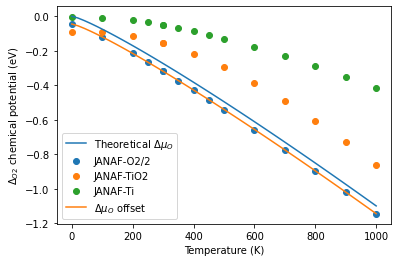

In [12]:
# Plot oxygen chemical potential
fig, ax1 = plt.subplots()
ax1.plot(T,delta_mu_O,label=r'Theoretical $\Delta$$\mu_O$')
ax1.scatter(O_janaf[1],O_janaf[0],label="JANAF-O2/2")
ax1.scatter(TiO2_janaf[1],TiO2_janaf[0],label="JANAF-TiO2")
offset=delta_mu_O[0]-O_janaf[0][0]
ax1.scatter(Ti_ref_janaf[1],Ti_ref_janaf[0]+offset,label="JANAF-Ti")
print("Offset is: ",offset," eV")
#plot difference
ax1.plot(T,delta_mu_O-offset,label=r'$\Delta$$\mu_O$ offset')
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\Delta_{O2}$ chemical potential (eV)')
plt.legend()
plt.show()